In [11]:
# inputs
source_dir = "clio_mb20_raw" # source file bucket
run_id = "try1_test32_11" # unique run id for job

In [25]:
from google.cloud import storage
storage_client = storage.Client()

import pandas as pd
import numpy as np
from math import ceil
import json

# info locations
process_dir = source_dir + "_process"
prefix = run_id + "/"

initloc = prefix + "init.json" # start file
comploc = prefix + "complete.json" # final file

align_dir = prefix + "align/affine_cache/" # affine cache
slice_write_dir = prefix + "align/write_cache/" # write cache
ng_write_dir = prefix + "neuroglancer/cache/" # write cache

ng_dir =  source_dir  + "_ng_" + run_id  # location of ng bucket
ng_meta = "neuroglancer/jpeg/info" # location of info

neuroglancer_addr = f"https://neuroglancer-demo.appspot.com/#!%7B%22layers%22%3A%5B%7B%22type%22%3A%22image%22%2C%22source%22%3A%7B%22url%22%3A%22precomputed%3A%2F%2Fgs%3A%2F%2F{ng_dir}%2Fneuroglancer%2Fjpeg%22%7D%2C%22tab%22%3A%22source%22%2C%22name%22%3A%22jpeg%22%7D%5D%2C%22selectedLayer%22%3A%7B%22layer%22%3A%22jpeg%22%2C%22visible%22%3Atrue%7D%7D"

def analyze_delays(prefix, total_tasks, hint=1):
    """Provides the following for a given stage:

    1. Make bar chart with number of tasks complete out of remaining and report total time
    2. Make graph of work per minute
    3. Print estimated time remaining
    """
    import warnings
    import tqdm
    
    # collect all time stamps
    blobs = storage_client.list_blobs(process_dir, prefix=prefix)
    create_times = []
    for blob in blobs:
        if blob.name.startswith(prefix+"worker"):
            continue
        create_times.append(blob.time_created)

    
    # print work per minute rates
    df = pd.DataFrame({"time": create_times})
    df = df.sort_values(by="time", ascending=True)
    warnings.simplefilter(action='ignore', category=UserWarning)
    
        
    # print bar chart and total time so far
    remaining = total_tasks - len(create_times)
    total_time = 0
    
    if len(create_times) > 0:
        total_time = (df["time"].iloc[-1]-df["time"].iloc[0])
        total_time = (total_time.total_seconds()/60)
    
    pbar = tqdm.tqdm(desc=f"Tasks completed in {total_time:.2f} minutes", bar_format="{l_bar}{bar}|{n_fmt}/{total_fmt}", initial=len(create_times), total=total_tasks)
    #pbar.set_description()
    
    if len(create_times) > 0:
        counts = pd.Series(index=df.time, data=np.array(df.count)).resample('1T').count()
        counts.sort_index(ascending=True)
        counts.plot.line()
    
    # estimate work time based on last 15 minutes
    remaining_time = 0
    rate = hint
    if remaining > 0 and len(create_times) > 0:
        rate = counts.sort_index(ascending=False)[0:15].mean()
        remaining_time = remaining / rate
    elif len(create_times) > 0:
        rate = counts.sort_index(ascending=False).mean()
    elif remaining > 0:
        remaining_time = remaining / rate

    #print(f"Total time {total_time:.2f} minutes")
    print(f"Estimated time remaining: {remaining_time:.2f} minutes")
    print(f"Task rate: {rate:.2f} per minute")
    return rate

# get job data
bucket = storage_client.bucket(process_dir)

# determine number of slices
blob = bucket.blob(initloc)
job_json = json.loads(blob.download_as_string())

num_slices = job_json["maxz"] - job_json["minz"] + 1

shards = ceil(num_slices**3 / (1024**3)) # estimate

try:
    # estimate ng work if possible from ng file
    bucket = storage_client.bucket(ng_dir)

    # determine number of slices
    blob = bucket.blob(ng_meta)
    
    ng_json = json.loads(blob.download_as_string())
    xb = ceil(ng_json["scales"][0]["size"][0] / 1024)
    yb = ceil(ng_json["scales"][0]["size"][1] / 1024)
    zb = ceil(num_slices / 1024)
    shards = xb*yb*zb
except:
    pass
    
# get runtime total
import time

total_runtime = 0
job_status = "not started"

start = 0
end = time.time()

blobs = storage_client.list_blobs(process_dir, prefix=initloc)

for blob in blobs:
    start = blob.time_created.timestamp()
    job_status = "started"
    
if start != 0:
    blobs = storage_client.list_blobs(process_dir, prefix=comploc)
    for blob in blobs:
        end = blob.time_created.timestamp()
        job_status = "completed"
    total_runtime = (end-start) / 60   

## Summary

In [22]:
print(f"status: {job_status}")
print(f"total runtime: {total_runtime:.2f} minutes")
if job_status == "completed":
    print(f"neuroglancer location: {neuroglancer_addr}")

status: started
total runtime: 5.84 minutes


## Alignment Stage

Affine transformation calculation for each image.

Tasks completed in 5.50 minutes:  19%|█▊        |198/1063

Estimated time remaining: 26.21 minutes
Task rate: 33.00 per minute


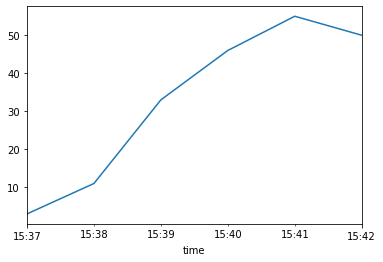

In [26]:
# alignment stage
align_rate = analyze_delays(align_dir, num_slices-1, hint=1)

## Slice Transform and Contrast Adjust Stage

Apply alignment and write out intermediate tiles

In [27]:
# slice write stage
slice_rate = analyze_delays(slice_write_dir, num_slices, hint=align_rate*4)

Tasks completed in 0.00 minutes:   0%|          |0/1064

Estimated time remaining: 8.06 minutes
Task rate: 132.00 per minute


## Export neuroglancer and chunks

In [28]:
# slice write stage
slice_rate = analyze_delays(ng_write_dir, shards, hint=3)

Tasks completed in 0.00 minutes:   0%|          |0/2

Estimated time remaining: 0.67 minutes
Task rate: 3.00 per minute
